In [1]:
import pandas as pd
import google_streetview.api
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from geopy import Point
from geopy.distance import geodesic

In [2]:
with open('apikey.txt') as f:
    api_key = f.readline()
    f.close

In [3]:
# Read intersection list from CSV
df = pd.read_csv('pbn_bearings1.csv')
df = df[df['intersection_street'].notnull()]

In [4]:
df.tail(10)

,Unnamed: 0,objectid,local_street,town,suburb,city,count,intersection_street,intersection_lat,intersection_lon,bearing,bearing_lat,bearing_lon
387728,16255,40235,VICTORIA STREET,Thornbury,Thornbury,Melbourne,2,BRETT STREET,-37.767647,144.967759,242.0,4846.645979,-37.747687
387729,16255,40235,VICTORIA STREET,Thornbury,Thornbury,Melbourne,2,ELIZABETH STREET,-37.767663,144.967909,242.0,4835.654371,-37.747687
387730,16255,40235,VICTORIA STREET,Thornbury,Thornbury,Melbourne,2,NASH STREET,-37.767710,144.968363,241.0,4802.562009,-37.747687
387731,16255,40235,VICTORIA STREET,Thornbury,Thornbury,Melbourne,2,MARKS STREET,-37.767759,144.968806,241.0,4770.531053,-37.747687
387732,16255,40235,VICTORIA STREET,Thornbury,Thornbury,Melbourne,2,SOUTH AUDLEY STREET,-37.767795,144.969140,241.0,4746.388613,-37.747687
387733,16255,40235,VICTORIA STREET,Thornbury,Thornbury,Melbourne,2,ABERDEEN STREET,-37.767905,144.970168,240.0,4672.510854,-37.747687
387734,16255,40235,VICTORIA STREET,Thornbury,Thornbury,Melbourne,2,COLLACE STREET,-37.768018,144.971228,239.0,4596.936721,-37.747687
387743,16264,40245,LAHINCH STREET,Thornbury,Thornbury,Melbourne,2,OPAL STREET,-37.744379,145.017325,7.0,155.689616,-37.746675
387744,16264,40245,LAHINCH STREET,Thornbury,Thornbury,Melbourne,2,OVANDO STREET,-37.745761,145.017106,27.0,1.124818,-37.746675
387745,16264,40245,LAHINCH STREET,Thornbury,Thornbury,Melbourne,2,BELL STREET,-37.746587,145.016972,187.0,10.045779,-37.746675


In [5]:
def offset_coordinates(lat1, lon1, bearing=0, meters=0):
    if (meters == 0):
        return str(lat1) + ', ' + str(lon1)
    return str(geodesic(meters=meters).destination(Point(lat1, lon1), bearing).format_decimal())

In [171]:
def gsv_sample(id, lat, lon, bearing, offset):
    location = offset_coordinates(lat, lon, bearing, offset)
    
    heading_offsets = [0, 90, 180, 270]
    
    for heading_offset in heading_offsets:
        heading = bearing + heading_offset
        if heading >- 360:
            heading = heading - 360
            
        params = [{
            'key': api_key,
            'size': '640x640',
            'location': location,
            'fov': '90',
            'pitch': '-20',
            'heading': str(heading)
        }]
            
        results = google_streetview.api.results(params)

        results.download_links('downloads/' + str(id) + '/' + str(offset) + '/' + str(heading_offset))
    
    fig = plt.figure(figsize=(20,20))
    
    for idx, heading_offset in enumerate(heading_offsets):
        image_path = 'downloads/' + str(id) + '/' + str(offset) + '/' + str(heading_offset) + '/gsv_0.jpg'
        img = mpimg.imread(image_path)

        plt.subplot(2, 2, idx+1)
        plt.imshow(img)
    plt.show()

In [172]:
def sample_location(id=0, offset=0, correction=0):
    if (id == 0):
        entry = df.sample()
        id = entry.index.tolist()[0]
    else:
        entry = df.filter(items=[id], axis=0)
            
    local_street        = entry['local_street'       ].iloc[0]
    town                = entry['town'               ].iloc[0]
    suburb              = entry['suburb'             ].iloc[0]
    city                = entry['city'               ].iloc[0]
    intersection_street = entry['intersection_street'].iloc[0]
    lat                 = entry['intersection_lat'   ].iloc[0]
    lon                 = entry['intersection_lon'   ].iloc[0]
    bearing             = entry['bearing'            ].iloc[0]
    
    bearing = bearing + correction
    if bearing >= 360:
        bearing = bearing - 360
        
    print(entry[['local_street', 'town', 'intersection_street', 'intersection_lat', 'intersection_lon', 'bearing']])
    print('Corrected Bearing: ' + str(bearing))
    
    gsv_sample(id, lat, lon, bearing, offset)
    
    entry.to_json('downloads/' + str(id) + '/' + str(offset) + '/sample.json')
    
    return id

In [77]:
def record_hit(id, offset=0, image_num=0):
    hits = open('downloads/hits.csv', 'a')
    hits.write(str(id) + ',' + str(offset) + ',' + str(image_num) + '\r\n')
    hits.close()

           local_street        town intersection_street  intersection_lat  \
38635  SPRINGFIELD ROAD  Nunawading  JOHN HOLLAND COURT        -37.810676   

       intersection_lon  bearing  
38635         145.15464    274.0  
Corrected Bearing: 274.0


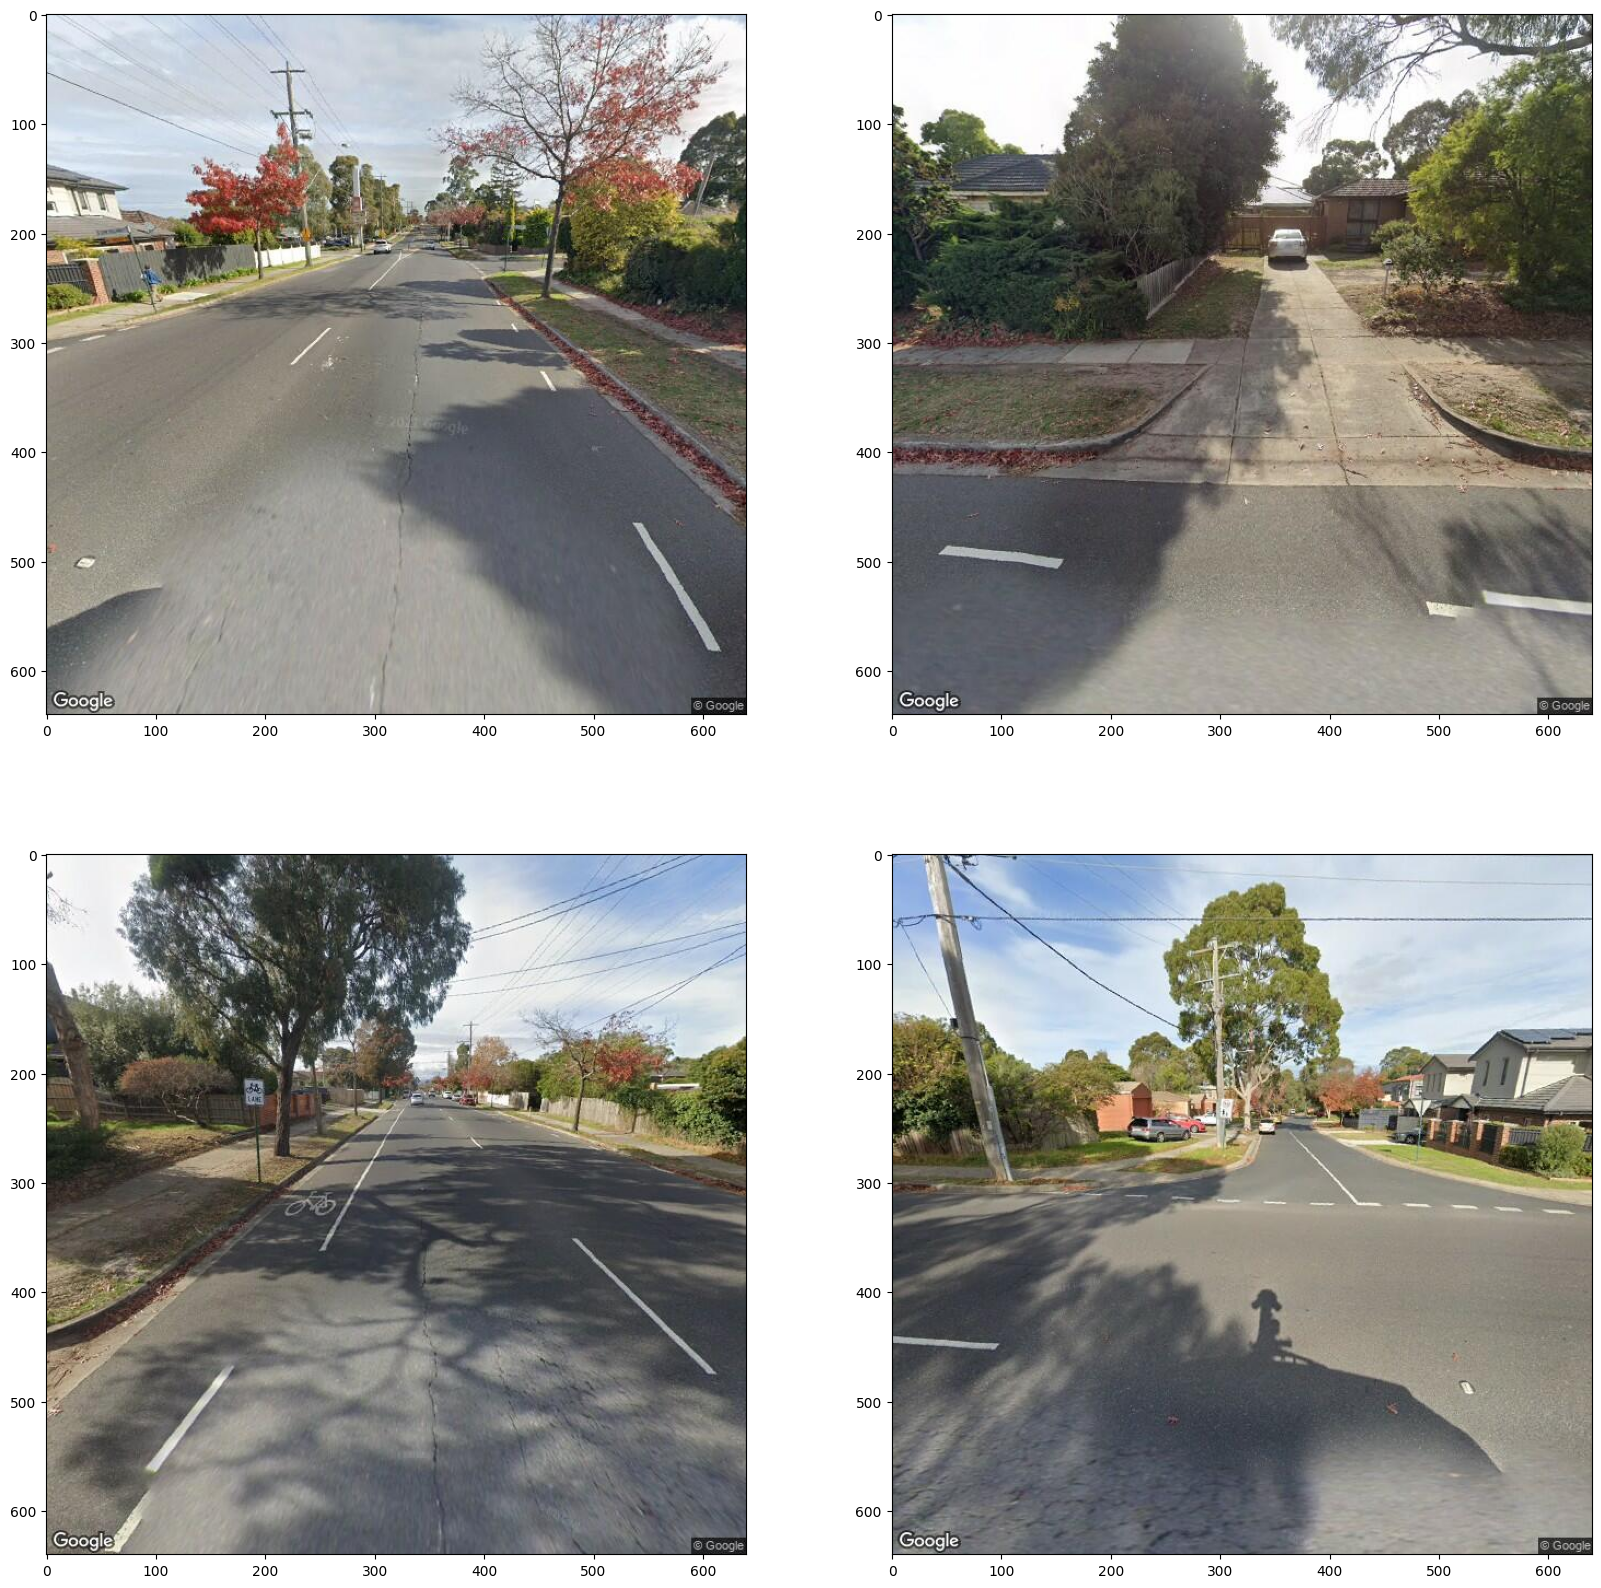

In [1052]:
correction = 0
offset     = 0

if offset==0 and correction==0:
    id = 38635

id = sample_location(id, offset, correction)

In [1053]:
image_num = 3

record_hit(id, offset, image_num)